
[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---------------------------------------- 2.6/2.6 MB 29.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395146 sha256=dbef2b02929d0540b04abeb0a55c8e6aeb235eaa5f091e8732d4e6216a427fa5
  Stored in directory: c:\users\ankit\appdata\local\pip\cache\wheels\b5\42\97\11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID No   200 non-null    int64  
 1   X       200 non-null    float64
 2   Y       200 non-null    float64
 3   pH      200 non-null    float64
 4   EC      200 non-null    float64
 5   %OC     200 non-null    float64
 6   AN      200 non

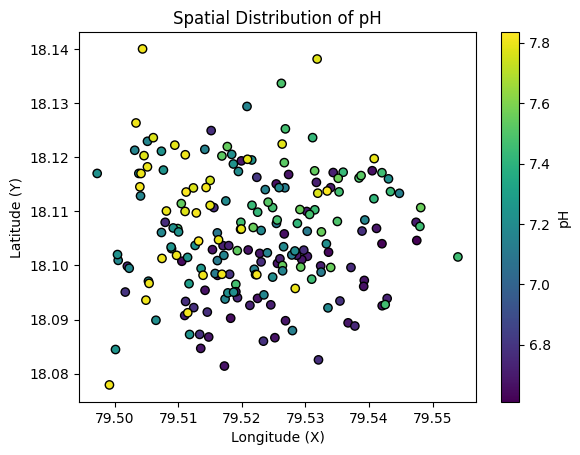

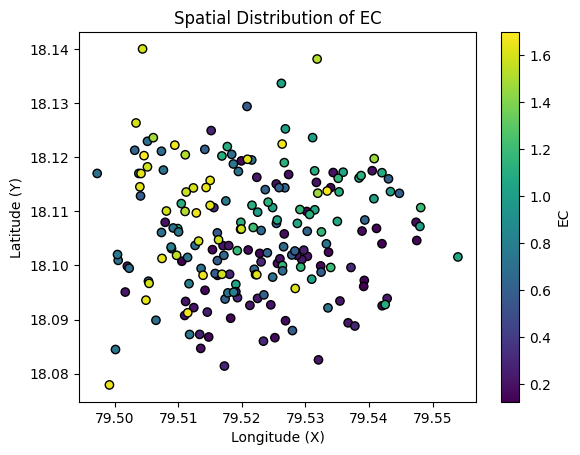

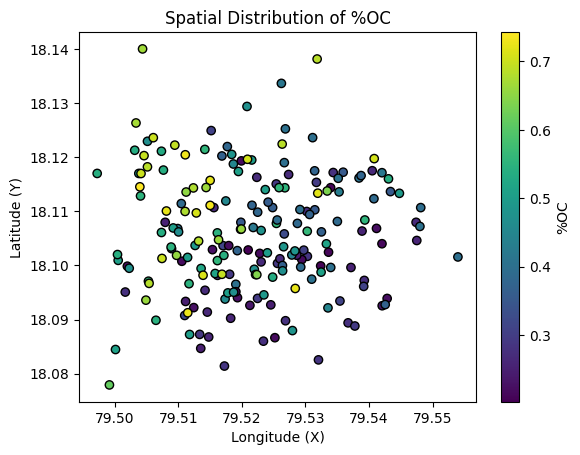

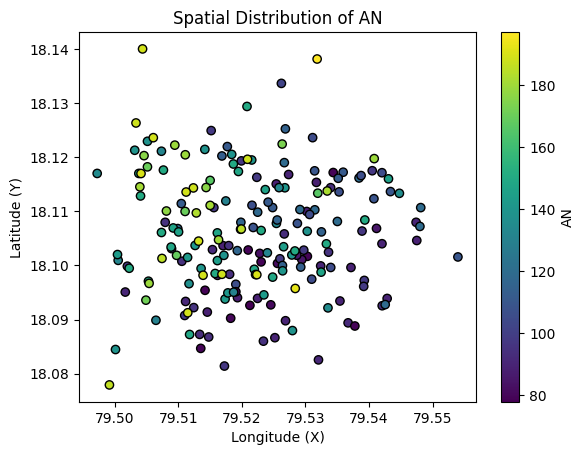

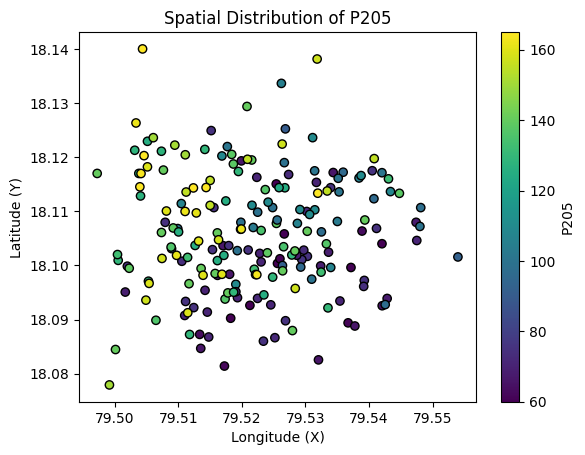

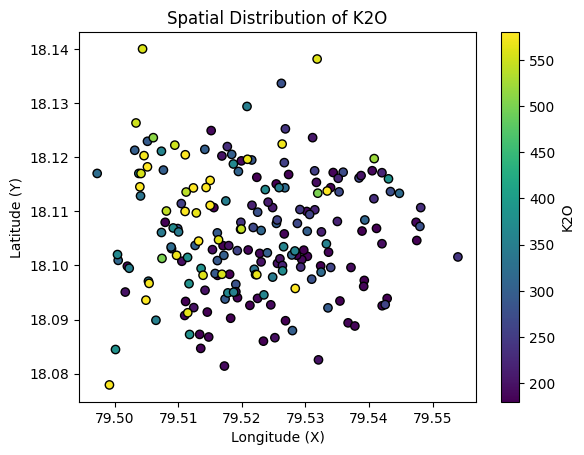


Processing attribute: pH


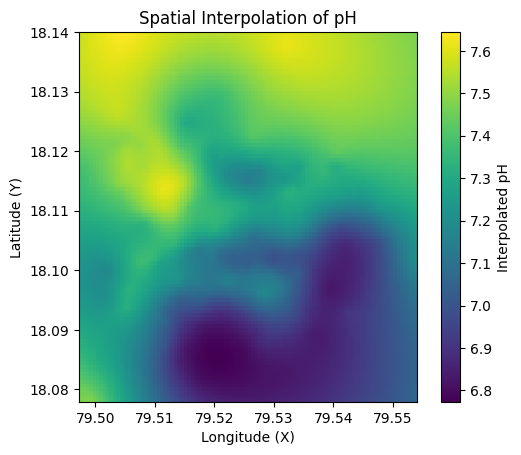

Moran's I for pH: 0.22680858030374113

Processing attribute: EC


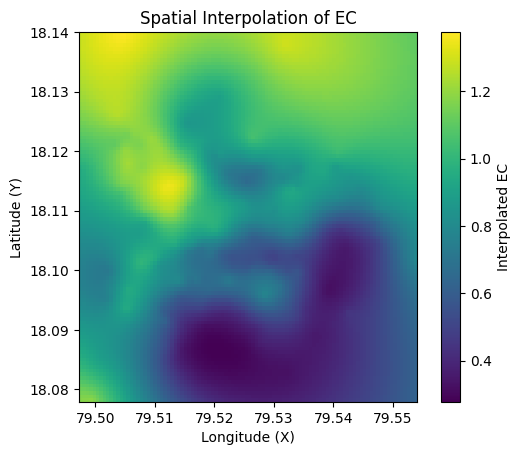

Moran's I for EC: 0.21039689339067622

Processing attribute: %OC


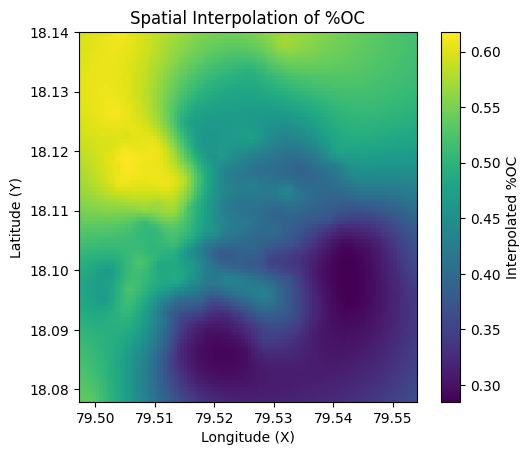

Moran's I for %OC: 0.24515729602119185

Processing attribute: AN


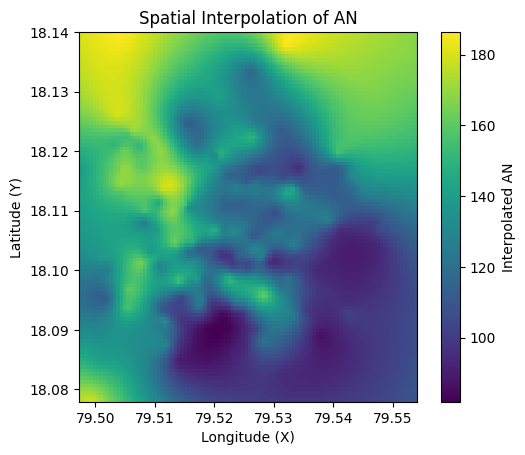

Moran's I for AN: 0.23657688663370724

Processing attribute: P205


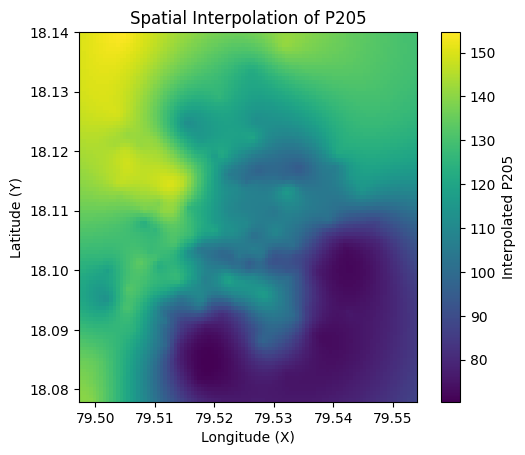

Moran's I for P205: 0.22351625591357457

Processing attribute: K2O


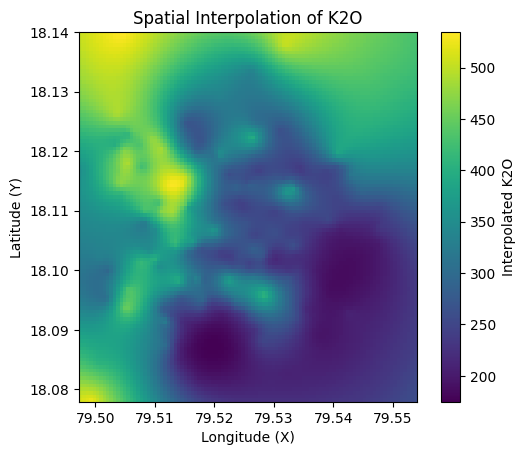

Moran's I for K2O: 0.23432381021640597

Variogram Parameters:
pH: [0.16955761 0.06008988 0.08556943]
EC: [0.29187445 0.06008988 0.12850421]
%OC: [0.02617008 0.06008988 0.012866  ]
AN: [2.23087755e+03 6.00898822e-02 1.20531805e+02]
P205: [1.61347034e+03 6.00898822e-02 4.20315798e+02]
K2O: [3.11089267e+04 6.00898822e-02 3.52432697e+03]


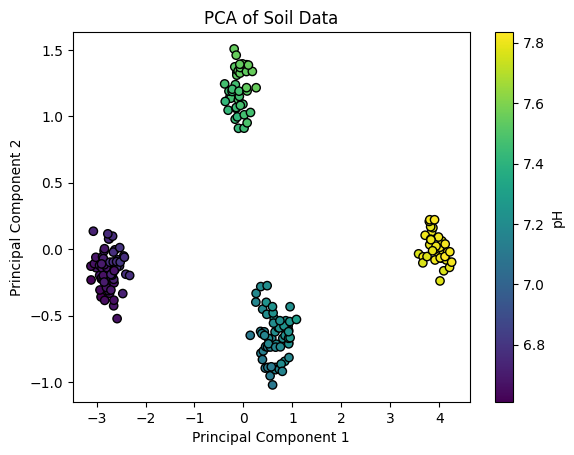

In [6]:
!pip install pandas numpy matplotlib pykrige libpysal esda scikit-learn pyclustering



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from libpysal.weights import KNN
from esda.moran import Moran
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pyclustering.cluster.fcm import fcm

# Load the dataset
data_path = 'nafiu_data_augmented.csv'  # Update this path if necessary
df = pd.read_csv(data_path)

# Clean column names to avoid formatting issues
df.columns = df.columns.str.strip()

# Display dataset info
print(df.info())

# Extract coordinates and attributes
x = df['X'].values
y = df['Y'].values
attributes = ['pH', 'EC', '%OC', 'AN', 'P205', 'K2O']

# 1. Exploratory Data Analysis (EDA)
print("Descriptive Statistics:\n", df[attributes].describe())

# Visualize spatial distribution for each attribute
for attr in attributes:
    plt.scatter(x, y, c=df[attr], cmap='viridis', edgecolor='k')
    plt.colorbar(label=attr)
    plt.title(f'Spatial Distribution of {attr}')
    plt.xlabel('Longitude (X)')
    plt.ylabel('Latitude (Y)')
    plt.show()

# 2. Geostatistical Analysis
variogram_results = {}
for attr in attributes:
    print(f"\nProcessing attribute: {attr}")

    # Extract attribute values
    z = df[attr].values

    # Perform Ordinary Kriging
    ok = OrdinaryKriging(x, y, z, variogram_model='spherical')
    variogram_results[attr] = ok.variogram_model_parameters

    # Create interpolation grid
    gridx = np.linspace(min(x), max(x), 100)
    gridy = np.linspace(min(y), max(y), 100)
    z_interp, _ = ok.execute('grid', gridx, gridy)

    # Plot interpolated map
    plt.imshow(z_interp, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='viridis')
    plt.colorbar(label=f'Interpolated {attr}')
    plt.title(f'Spatial Interpolation of {attr}')
    plt.xlabel('Longitude (X)')
    plt.ylabel('Latitude (Y)')
    plt.show()

    # Calculate Moran's I for spatial autocorrelation using K-Nearest Neighbors spatial weights
    knn = KNN.from_array(np.column_stack((x, y)), k=8)  # 8 nearest neighbors for each point
    moran = Moran(z, knn)  # Use the actual attribute values (e.g., pH)
    print(f"Moran's I for {attr}: {moran.I}")

# Display variogram parameters for all attributes
print("\nVariogram Parameters:")
for attr, params in variogram_results.items():
    print(f"{attr}: {params}")

# 3. Management Zone Delineation using PCA and Fuzzy Clustering (FCM)
# Standardize the data before applying PCA and clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[attributes])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 components for easy visualization
pca_result = pca.fit_transform(df_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Visualize PCA results
plt.scatter(df['PCA1'], df['PCA2'], c=df['pH'], cmap='viridis', edgecolor='k')
plt.colorbar(label='pH')
plt.title('PCA of Soil Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

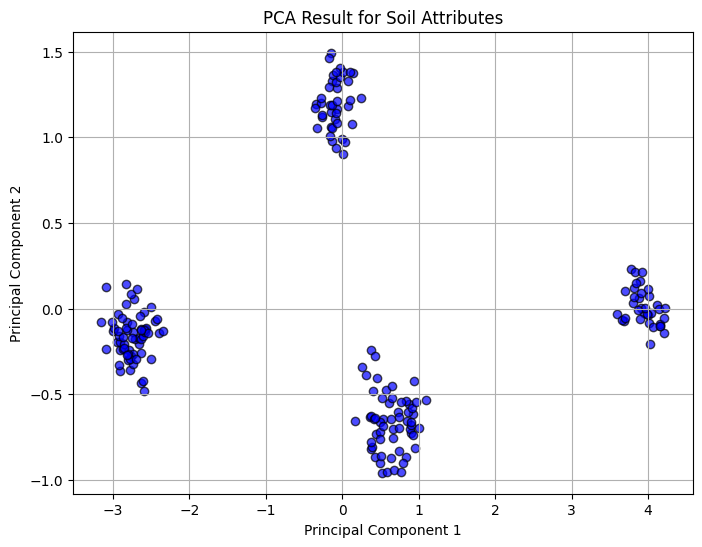

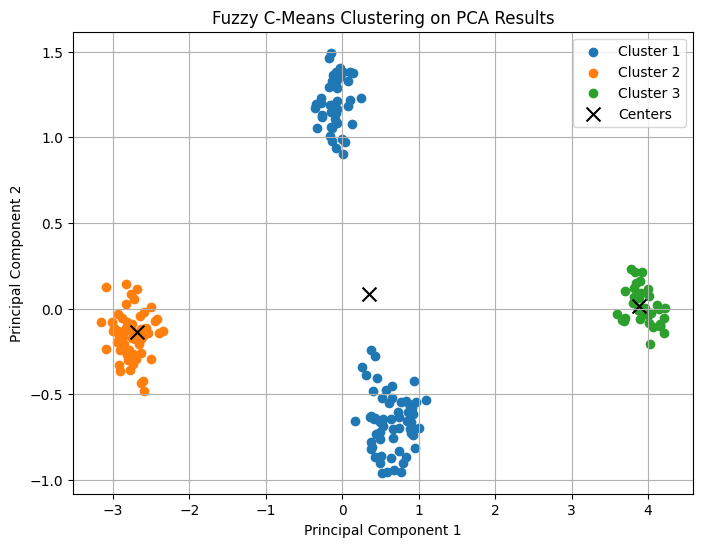

Clustered data saved to /content/nafiu_data_with_clusters.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyclustering.cluster.fcm import fcm
from pyclustering.utils import draw_clusters

# Load the dataset
data_path = '/content/nafiu data.csv'  # Ensure this path is correct
df = pd.read_csv(data_path)

# Clean column names
df.columns = df.columns.str.strip()

# Select soil nutritional attributes
attributes = ['pH', 'EC', '%OC', 'AN', 'P205', 'K2O']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[attributes])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Add PCA results back to the dataframe
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Visualize PCA results
plt.figure(figsize=(8, 6))
plt.scatter(df['PCA1'], df['PCA2'], c='blue', edgecolor='k', alpha=0.7)
plt.title('PCA Result for Soil Attributes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Fuzzy C-Means Clustering
# Define initial centers (choose random samples or specify centers manually)
initial_centers = np.random.choice(len(df), 3, replace=False)  # 3 clusters
fcm_instance = fcm(data=pca_result, initial_centers=pca_result[initial_centers])

# Perform clustering
fcm_instance.process()
clusters = fcm_instance.get_clusters()
cluster_centers = fcm_instance.get_centers()

# Assign cluster labels to the original dataset
labels = np.zeros(len(df))
for cluster_id, cluster_points in enumerate(clusters):
    for point in cluster_points:
        labels[point] = cluster_id

df['Cluster'] = labels

# Visualize Clusters in PCA Space
plt.figure(figsize=(8, 6))
for cluster_id, cluster_points in enumerate(clusters):
    points = pca_result[cluster_points]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster_id + 1}')
plt.scatter(
    np.array(cluster_centers)[:, 0],
    np.array(cluster_centers)[:, 1],
    color='black',
    marker='x',
    label='Centers',
    s=100
)
plt.title('Fuzzy C-Means Clustering on PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Save the clustered data to a new CSV file
output_path = '/content/nafiu_data_with_clusters.csv'
df.to_csv(output_path, index=False)
print(f"Clustered data saved to {output_path}")



Regression Models RMSE:
 {'Random Forest': 0.010088680501186133, 'Linear Regression': 3.9720546451956367e-16, 'Lasso Regression': 0.10022514617523565, 'Ridge Regression': 0.012689723096013971, 'Gradient Boosting': 0.00568492583972095, 'SVR': 0.06473429362351302}

Classification Models Accuracy:
 {'Random Forest': 0.99375, 'Gradient Boosting': 0.99375}
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Random Forest Parameters:
 {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Model RMSE: 0.006378251178667521
K-Means Silhouette Score: 0.7233865804062941


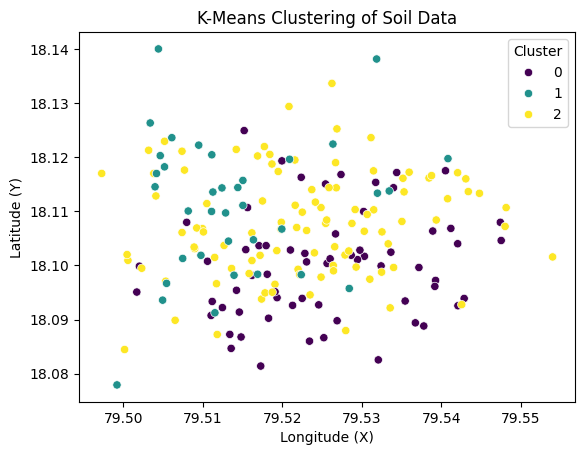


Feature Importances:
   Feature  Importance
0      pH    0.314222
1      EC    0.202101
3      AN    0.159345
4    P205    0.139786
2     %OC    0.127689
5     K2O    0.056857


OSError: Cannot save file into a non-existent directory: '\content'

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, accuracy_score, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data_path = 'nafiu_data_augmented.csv'
df = pd.read_csv(data_path)

# Clean column names
df.columns = df.columns.str.strip()

# Define features and targets
features = ['pH', 'EC', '%OC', 'AN', 'P205', 'K2O']
target_regression = 'pH'  # Example target for regression
target_classification = 'Fertility_Class'  # Replace with actual soil class label if available

# Data Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

# Create a dummy target for classification if not available
if target_classification not in df.columns:
    df[target_classification] = (df['pH'] > df['pH'].median()).astype(int)  # Example binary class

y_regression = df[target_regression]
y_classification = df[target_classification]

# Train-Test Split
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_classification, test_size=0.2, random_state=42)

# Define models for regression and classification
reg_models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf')
}

clf_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate regression models with cross-validation
reg_results = {}
for name, model in reg_models.items():
    scores = cross_val_score(model, X_train, y_train_reg, cv=5, scoring='neg_mean_squared_error')
    reg_results[name] = np.sqrt(-scores.mean())
print("\nRegression Models RMSE:\n", reg_results)

# Train and evaluate classification models with cross-validation
clf_results = {}
for name, model in clf_models.items():
    scores = cross_val_score(model, X_train, y_train_clf, cv=5, scoring='accuracy')
    clf_results[name] = scores.mean()
print("\nClassification Models Accuracy:\n", clf_results)

# Perform hyperparameter tuning for a model (example: Random Forest for regression)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train, y_train_reg)
best_model = grid_search.best_estimator_
print("\nBest Random Forest Parameters:\n", grid_search.best_params_)

# Final evaluation with the best model
y_pred_best = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_best))
print(f"Best Model RMSE: {final_rmse}")

# Clustering (K-Means)
kmeans = KMeans(n_clusters=3, random_state=42)  # 3 clusters for management zones
clusters = kmeans.fit_predict(X)
df['Cluster'] = clusters
silhouette = silhouette_score(X, clusters)
print(f"K-Means Silhouette Score: {silhouette}")

# Visualize Clustering Results
sns.scatterplot(x=df['X'], y=df['Y'], hue=df['Cluster'], palette='viridis')
plt.title('K-Means Clustering of Soil Data')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

# Feature Importance (Random Forest Regressor)
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", feature_importances)

# Save Results
df.to_csv('/content/soil_analysis_results.csv', index=False)
print("Results saved to 'soil_analysis_results.csv'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('/content/nafiu data.csv')

# Clean column names (strip spaces to avoid issues)
df.columns = df.columns.str.strip()

# Print column names to verify
print("Columns in the dataset:", df.columns)

# Function to add noise to the data
def add_noise(data, noise_factor=0.01):
    noise = np.random.normal(loc=0, scale=noise_factor, size=data.shape)
    return data + noise

# Apply noise augmentation to the numeric columns
numeric_columns = ['X', 'Y', 'pH', 'EC', '%OC', 'AN', 'P205', 'K2O']
augmented_data = df.copy()

# Check that the numeric columns exist before applying the noise
missing_columns = [col for col in numeric_columns if col not in df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    augmented_data[numeric_columns] = add_noise(augmented_data[numeric_columns], noise_factor=0.01)

# Features and target variable for regularization demonstration
X = df[numeric_columns]
y = df['pH']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression (L2 Regularization)
ridge_model = Ridge(alpha=1.0)  # 'alpha' controls the strength of regularization
ridge_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = ridge_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error with Ridge Regression: {mse}')

# Save the augmented data to a new CSV file
augmented_data.to_csv('/content/nafiu_data_augmented.csv', index=False)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt

# Load the augmented dataset
df = pd.read_csv('/content/nafiu_data_augmented.csv')

# Clean column names (strip spaces to avoid issues)
df.columns = df.columns.str.strip()

# Check for missing values and handle them (fill with the mean for simplicity)
df.fillna(df.mean(), inplace=True)

# Add noise to the dataset to reduce overfitting
noise_factor = 0.1  # Adjust this value based on how much noise you want to add
noise = np.random.normal(0, noise_factor, df.shape)
df_noisy = df + noise

# Features and target variable for modeling
numeric_columns = ['X', 'Y', 'pH', 'EC', '%OC', 'AN', 'P205', 'K2O']
X = df_noisy[numeric_columns]
y = df_noisy['pH']  # Target variable: 'pH'

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store models and their names
models = {
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
}

# Hyperparameter grids for model tuning
param_grids = {
    'Lasso Regression': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'ElasticNet Regression': {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9, 1.0]},
    'Random Forest Regressor': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'Gradient Boosting Regressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]},
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']},
    'Decision Tree Regressor': {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    'K-Nearest Neighbors Regressor': {'n_neighbors': [3, 5, 7, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
}

# Create a custom function to handle XGBoost cross-validation
def xgboost_cv(model, X_train, y_train, num_round=100):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_round, nfold=5, stratified=False, seed=42)
    return cv_results['test-rmse-mean'].min(), cv_results['test-rmse-mean'].idxmin()

# Dictionary to store evaluation results
results = {}

# Train each model, evaluate, and store the results
for model_name, model in models.items():
    # Apply GridSearchCV for hyperparameter tuning
    if model_name in param_grids:
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_scaled, y_train)
        model = grid_search.best_estimator_  # Use the best model from GridSearchCV

    # Apply cross-validation to estimate generalization performance
    if model_name == 'XGBoost Regressor':  # Use custom XGBoost cv
        mse, best_iteration = xgboost_cv(model, X_train_scaled, y_train)
        results[model_name] = {'MSE': mse**2, 'R2': None, 'CV Mean MSE': mse**2, 'Best Iteration': best_iteration}
    else:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
        # Fit the model
        model.fit(X_train_scaled, y_train)
        # Make predictions
        y_pred_train = model.predict(X_train_scaled)  # Training predictions
        y_pred_test = model.predict(X_test_scaled)  # Testing predictions

        # Calculate evaluation metrics
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)

        # Store results including cross-validation scores
        results[model_name] = {
            'MSE Train': mse_train,
            'MSE Test': mse_test,
            'R2 Train': r2_train,
            'R2 Test': r2_test,
            'CV Mean MSE': -cv_scores.mean()  # Mean MSE from cross-validation
        }

# Create a DataFrame for the results
results_df = pd.DataFrame(results).T

# Sort the results by R2 (test) score (highest first) and then by MSE (test) (lowest first)
results_df_sorted = results_df.sort_values(by=['R2 Test', 'MSE Test'], ascending=[False, True])

# Identify and move overfitting models to the bottom of the ranking
overfitting_models = []
for model_name, row in results_df_sorted.iterrows():
    if row['R2 Train'] - row['R2 Test'] > 0.1:  # Arbitrary threshold to detect overfitting
        overfitting_models.append(model_name)

# Place overfitting models last
final_sorted_df = results_df_sorted[~results_df_sorted.index.isin(overfitting_models)]
final_sorted_df = pd.concat([results_df_sorted[results_df_sorted.index.isin(overfitting_models)], final_sorted_df])

# Print the sorted evaluation results
print("Model Evaluation Results (Ranked by R2 and MSE for Test set):")
print(final_sorted_df)

# Save the results to a CSV file
final_sorted_df.to_csv('/content/Rregularized_Model_Evaluation_results_comparison.csv')


Model Evaluation Results (Ranked by R2 and MSE for Test set):
                                  MSE Train  MSE Test  R2 Train   R2 Test  \
K-Nearest Neighbors Regressor  2.126218e-17  0.015220  1.000000  0.899000   
ElasticNet Regression          6.554195e-05  0.000047  0.999648  0.999685   
Lasso Regression               1.000000e-04  0.000083  0.999463  0.999448   
Gradient Boosting Regressor    3.767834e-07  0.000106  0.999998  0.999294   
Random Forest Regressor        4.043985e-05  0.000178  0.999783  0.998821   
Decision Tree Regressor        8.446638e-05  0.000314  0.999547  0.997914   
Support Vector Regression      4.111363e-03  0.007075  0.977935  0.953046   

                               CV Mean MSE  
K-Nearest Neighbors Regressor     0.013140  
ElasticNet Regression             0.000069  
Lasso Regression                  0.000103  
Gradient Boosting Regressor       0.000150  
Random Forest Regressor           0.000361  
Decision Tree Regressor           0.000511  
Suppor

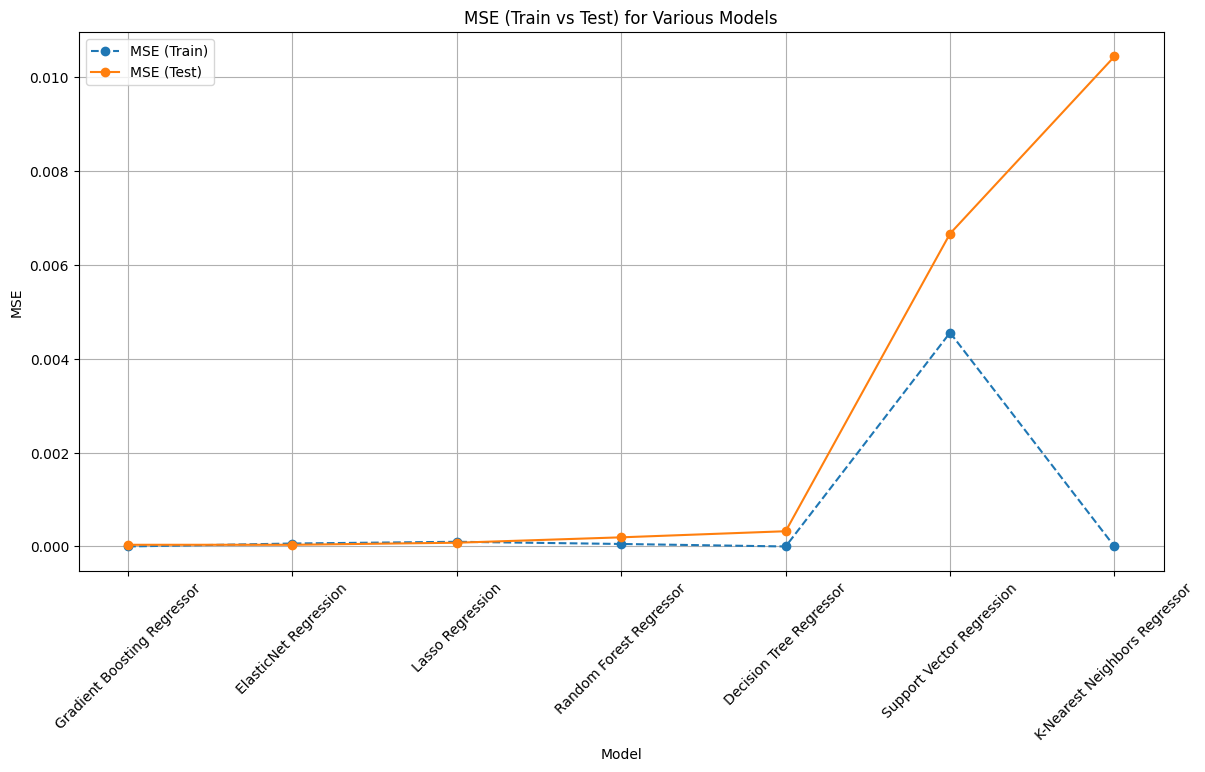

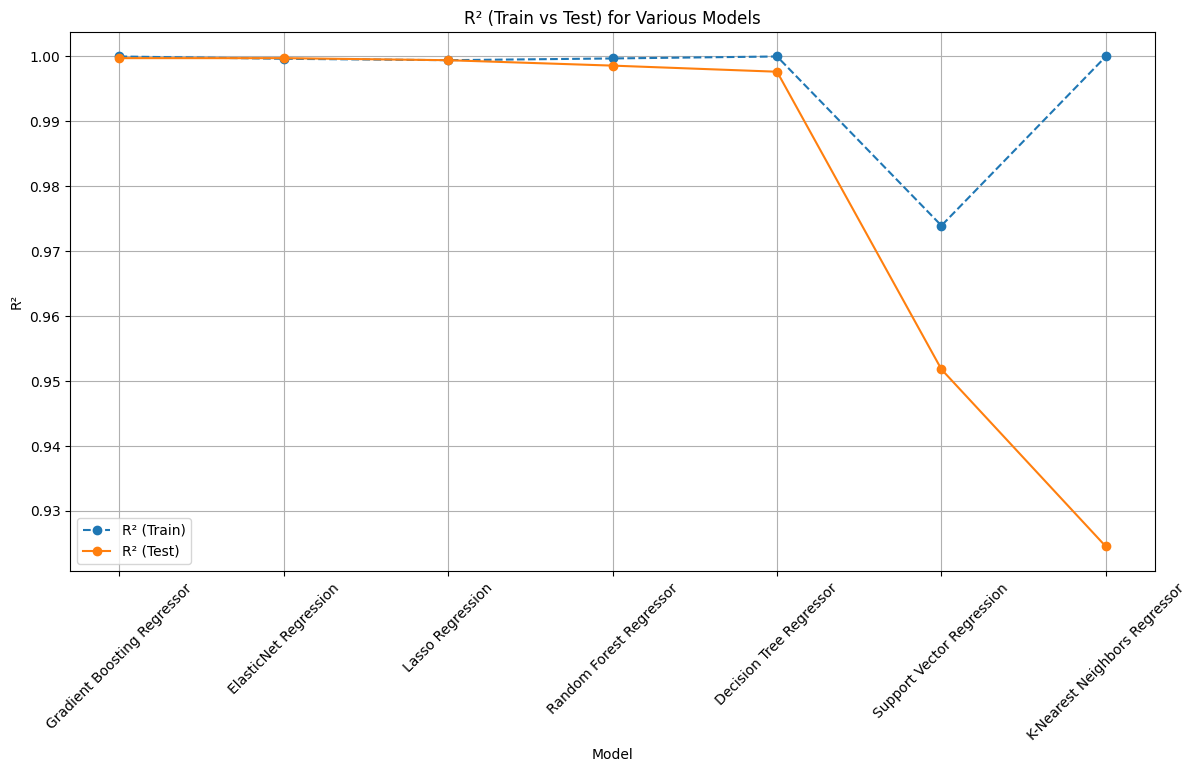

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    "Model": [
        "Gradient Boosting Regressor",
        "ElasticNet Regression",
        "Lasso Regression",
        "Random Forest Regressor",
        "Decision Tree Regressor",
        "Support Vector Regression",
        "K-Nearest Neighbors Regressor"
    ],
    "MSE (Train)": [
        3.304224e-07,
        6.297804e-05,
        1.000000e-04,
        5.337099e-05,
        0.000000e+00,
        4.558189e-03,
        1.022705e-16
    ],
    "MSE (Test)": [
        0.000036,
        0.000036,
        0.000080,
        0.000195,
        0.000325,
        0.006670,
        0.010446
    ],
    "R² (Train)": [
        0.999998,
        0.999640,
        0.999428,
        0.999695,
        1.000000,
        0.973925,
        1.000000
    ],
    "R² (Test)": [
        0.999742,
        0.999741,
        0.999423,
        0.998590,
        0.997649,
        0.951769,
        0.924465
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

# Plot MSE for train and test sets
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['MSE (Train)'], marker='o', label='MSE (Train)', linestyle='--')
plt.plot(df.index, df['MSE (Test)'], marker='o', label='MSE (Test)')
plt.title('MSE (Train vs Test) for Various Models')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot R² for train and test sets
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['R² (Train)'], marker='o', label='R² (Train)', linestyle='--')
plt.plot(df.index, df['R² (Test)'], marker='o', label='R² (Test)')
plt.title('R² (Train vs Test) for Various Models')
plt.xlabel('Model')
plt.ylabel('R²')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


<ipython-input-3-d31f7e9054b0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='CV Mean MSE', data=df, palette='viridis')


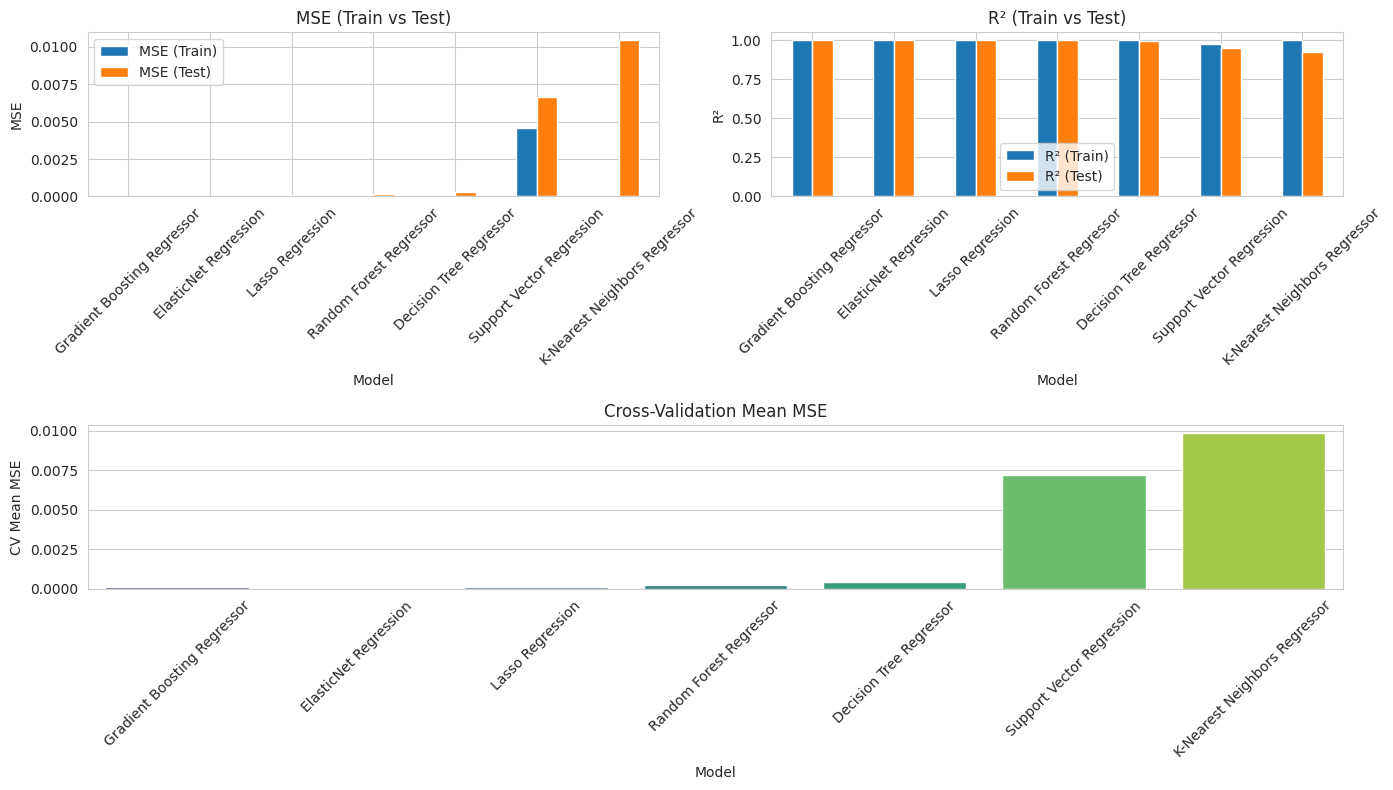

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    "Model": [
        "Gradient Boosting Regressor",
        "ElasticNet Regression",
        "Lasso Regression",
        "Random Forest Regressor",
        "Decision Tree Regressor",
        "Support Vector Regression",
        "K-Nearest Neighbors Regressor"
    ],
    "MSE (Train)": [
        3.304224e-07,
        6.297804e-05,
        1.000000e-04,
        5.337099e-05,
        0.000000e+00,
        4.558189e-03,
        1.022705e-16
    ],
    "MSE (Test)": [
        0.000036,
        0.000036,
        0.000080,
        0.000195,
        0.000325,
        0.006670,
        0.010446
    ],
    "R² (Train)": [
        0.999998,
        0.999640,
        0.999428,
        0.999695,
        1.000000,
        0.973925,
        1.000000
    ],
    "R² (Test)": [
        0.999742,
        0.999741,
        0.999423,
        0.998590,
        0.997649,
        0.951769,
        0.924465
    ],
    "CV Mean MSE": [
        0.000129,
        0.000068,
        0.000104,
        0.000259,
        0.000453,
        0.007224,
        0.009873
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set the figure size and style
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Plot MSE for train and test sets
plt.subplot(2, 2, 1)
df.plot(kind='bar', x='Model', y=['MSE (Train)', 'MSE (Test)'], ax=plt.gca(), title='MSE (Train vs Test)')
plt.ylabel('MSE')
plt.xticks(rotation=45)

# Plot R² for train and test sets
plt.subplot(2, 2, 2)
df.plot(kind='bar', x='Model', y=['R² (Train)', 'R² (Test)'], ax=plt.gca(), title='R² (Train vs Test)')
plt.ylabel('R²')
plt.xticks(rotation=45)

# Plot CV Mean MSE
plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='CV Mean MSE', data=df, palette='viridis')
plt.title('Cross-Validation Mean MSE')
plt.ylabel('CV Mean MSE')
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
